In [1]:
# import argparse

# parser = argparse.ArgumentParser(description="Choose RNN module: LSTM or GRU")
# parser.add_argument("--rnn_module", type=str, default="LSTM", help="Choose RNN module: LSTM or GRU")
# args = parser.parse_args()

#Choose GRU or LSTM here

#rnn = "GRU"
rnn = "LSTM"

In [2]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

import matplotlib.pyplot as plt


import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import scipy.io as sio

from tqdm import trange, tqdm

# Import the single DOF finite difference model
from mlp_singledof_rnn import MLP, MLPProjectionFilter, CustomGRULayer, GRU_Hidden_State, CustomLSTMLayer, LSTM_Hidden_State



/home/alinjar/simple_training_warm_start/RNN


In [3]:
class TrajDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, inp, theta_init, v_start, v_goal):
        # input
        self.inp = inp 
        self.theta_init = theta_init
        self.v_start = v_start
        self.v_goal = v_goal

    def __len__(self):
        return len(self.inp)    

    def __getitem__(self, idx):
        # Input
        inp = self.inp[idx]
        theta_init = self.theta_init[idx]
        v_start = self.v_start[idx]
        v_goal = self.v_goal[idx]

        return (torch.tensor(inp).float(),
                torch.tensor(theta_init).float(),
                torch.tensor(v_start).float(),
                torch.tensor(v_goal).float())

In [4]:
def sample_uniform_trajectories(key, var_min, var_max, dataset_size, nvar):
    rng = np.random.default_rng(seed=key)
    xi_samples = rng.uniform(
        low=var_min,
        high=var_max,
        size=(dataset_size, nvar)
    )
    return xi_samples, rng

In [5]:
#Parameters for MLP model

num_batch = 1000
num_dof=1
num_steps=50
timestep=0.05
v_max=1.0
a_max=2.0
j_max=5.0
p_max=180.0*np.pi/180.0 
theta_init=0.0
maxiter_projection = 5
nvar_single = num_steps
nvar = num_dof * nvar_single
theta_init_min=-np.pi
theta_init_max=np.pi

In [6]:
#calculating number of constraints
num_acc = num_steps - 1
num_jerk = num_acc - 1
num_pos = num_steps
num_vel_constraints = 2 * num_steps * num_dof
num_acc_constraints = 2 * num_acc * num_dof
num_jerk_constraints = 2 * num_jerk * num_dof
num_pos_constraints = 2 * num_pos * num_dof
num_total_constraints = (num_vel_constraints + num_acc_constraints + 
                            num_jerk_constraints + num_pos_constraints)




In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

#### creating dataset

dataset_size = num_batch*20 #200000

theta_init, rng_theta_init = sample_uniform_trajectories(41, var_min= theta_init_min, var_max = theta_init_max, dataset_size=dataset_size, nvar=1)
#print("theta_init", theta_init.shape)
v_start, rng_v_start = sample_uniform_trajectories(40, var_min =-1.0*v_max, var_max = 1.0*v_max, dataset_size=dataset_size, nvar=1)
#print("v_start", v_start.shape)
v_goal, rng_v_goal = sample_uniform_trajectories(39, var_min =-1.0*v_max, var_max = 1.0*v_max, dataset_size=dataset_size, nvar=1)

#For training
xi_samples, rng = sample_uniform_trajectories(42, var_min=-v_max, var_max=v_max ,dataset_size=dataset_size, nvar=nvar)

#For validation
xi_val, rng_val = sample_uniform_trajectories(43, var_min=-v_max, var_max=v_max ,dataset_size=dataset_size, nvar=nvar)

# xi_samples = torch.from_numpy(xi_samples)
# xi_val = torch.from_numpy(xi_val)

inp = np.hstack(( xi_samples, theta_init, v_start, v_goal))

inp_val = np.hstack(( xi_val, theta_init, v_start, v_goal))

Using cuda device


In [8]:
print("inp_mean", inp.mean())
print("inp_std", inp.std())

inp_mean -0.00017285970188430394
inp_std 0.6235914652792635


In [9]:

# A Torch version of the same is used in decoder function of corresponding MLP class for training
#Statistical Parameters:Median, Q1, Q3, IQR for all features

inp_median_ = np.median(inp, axis=0)
inp_q1 = np.percentile(inp, 25, axis=0)
inp_q3 = np.percentile(inp, 75, axis=0)
inp_iqr_ = inp_q3 - inp_q1


# Handle constant features
inp_iqr_ = np.where(inp_iqr_ == 0, 1, inp_iqr_)

print("input shape: ", inp.shape)
print(inp_median_.shape)
print(inp_q1.shape)
print(inp_q3.shape)
print(inp_iqr_.shape)

# print(np.array_repr(inp_median_))
# print(np.array_repr(inp_iqr_))


inp_val_median_ = np.median(inp_val, axis=0)
inp_val_q1 = np.percentile(inp_val, 25, axis=0)
inp_val_q3 = np.percentile(inp_val, 75, axis=0)
inp_val_iqr_ = inp_val_q3 - inp_val_q1


# Handle constant features
inp_val_iqr_ = np.where(inp_val_iqr_ == 0, 1, inp_val_iqr_)

print("input shape: ", inp_val.shape)
print(inp_val_median_.shape)
print(inp_val_q1.shape)
print(inp_val_q3.shape)
print(inp_val_iqr_.shape)

# print(np.array_repr(inp_median_))
# print(np.array_repr(inp_iqr_))



input shape:  (20000, 53)
(53,)
(53,)
(53,)
(53,)
input shape:  (20000, 53)
(53,)
(53,)
(53,)
(53,)


In [10]:
# Using PyTorch Dataloader
train_dataset = TrajDataset(inp, theta_init, v_start, v_goal)
val_dataset = TrajDataset(inp_val, theta_init, v_start, v_goal)

train_loader = DataLoader(train_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)


In [11]:

if rnn == "GRU":
    print("Training with GRU")
    #GRU handling
    rnn = "GRU"
    gru_input_size = 3*num_total_constraints+3*nvar
    # print(gru_input_size)
    gru_hidden_size = 512
    # gru_output_size = (2*nvar)**2+2*nvar
    gru_output_size = num_total_constraints+nvar
    # gru_context_size = mlp_planner_inp_dim

    gru_context = CustomGRULayer(gru_input_size, gru_hidden_size, gru_output_size)

    rnn_context = gru_context


    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = gru_hidden_size

    gru_init  =  GRU_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)
    
    rnn_init = gru_init
    ##
elif rnn == "LSTM":
    print("Training with LSTM")
    #LSTM handling
    rnn = "LSTM"
    lstm_input_size = 3*num_total_constraints+3*nvar
    # print(lstm_input_size)
    lstm_hidden_size = 512
    # lstm_output_size = (2*nvar)**2+2*nvar
    lstm_output_size = num_total_constraints+nvar
    # lstm_context_size = mlp_planner_inp_dim

    lstm_context = CustomLSTMLayer(lstm_input_size, lstm_hidden_size, lstm_output_size)

    rnn_context = lstm_context

    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = lstm_hidden_size

    lstm_init = LSTM_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)

    rnn_init = lstm_init

    ##

##


Training with LSTM


In [12]:

enc_inp_dim = np.shape(inp)[1] 
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 2*nvar + num_total_constraints #( xi_samples- 0:nvar, lamda_smples- nvar:2*nvar)

mlp =  MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)

In [13]:


model = MLPProjectionFilter(mlp=mlp,rnn_context=rnn_context, rnn_init = rnn_init, num_batch = num_batch,num_dof=num_dof,num_steps=num_steps,
							timestep=timestep,v_max=v_max,a_max=a_max,j_max=j_max,p_max=p_max, 
							maxiter_projection=maxiter_projection, rnn=rnn).to(device)

print(type(model))                            

<class 'mlp_singledof_rnn.MLPProjectionFilter'>


In [14]:
epochs = 100
#step, beta = 0, 1.0 # 3.5
optimizer = optim.AdamW(model.parameters(), lr = 1e-4, weight_decay=6e-5)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1, verbose=True)

losses = []
last_loss = torch.inf
avg_train_loss, avg_primal_loss, avg_fixed_point_loss, avg_projection_loss = [], [], [], []
avg_val_loss = []
for epoch in range(epochs):
    
    # Train Loop
    losses_train, primal_losses, fixed_point_losses, projection_losses = [], [], [], []
    
    for (inp, theta_init, v_start, v_goal) in tqdm(train_loader):
        
        # Input and Output 
        inp = inp.to(device)
        theta_init = theta_init.to(device)
        v_start = v_start.to(device)
        v_goal = v_goal.to(device)
        
        xi_projected, accumulated_res_fixed_point, accumulated_res_primal, \
        accumulated_res_primal_temp, accumulated_res_fixed_point_temp = model(inp, theta_init, v_start, v_goal, rnn)

        xi_samples_inp = inp[:, :nvar]

        primal_loss, fixed_point_loss, projection_loss, loss = model.mlp_loss(accumulated_res_primal, 
                                                                              accumulated_res_fixed_point, xi_samples_inp, xi_projected)

        
        optimizer.zero_grad() #clears the gradients of the model parameters
        loss.backward() #computes the gradients of the model parameters
        
        
        # #Gradient Norm check
        # total_norm = 0.0
        # for p in model.parameters():
        #     if p.grad is not None:
        #         param_norm = p.grad.data.norm(2)  # L2 norm
        #         total_norm += param_norm.item() ** 2

        # total_norm = total_norm ** 0.5
        # print(f"Gradient L2 norm: {total_norm:.4f}")
        
        ##Gradient Norm clipping
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


        optimizer.step() #updates the model parameters (e.g. weights and biases)
        
        losses_train.append(loss.detach().cpu().numpy()) 
        primal_losses.append(primal_loss.detach().cpu().numpy())
        fixed_point_losses.append(fixed_point_loss.detach().cpu().numpy())
        projection_losses.append(projection_loss.detach().cpu().numpy())
        
    if epoch % 2 == 0:
        
        # Validation 
        model.eval()
        val_losses = []

        with torch.no_grad():
            for (inp_val, theta_init, v_start, v_goal) in tqdm(val_loader):
                inp_val = inp_val.to(device)
                theta_init = theta_init.to(device)
                v_start = v_start.to(device)
                v_goal =  v_goal.to(device)

                xi_projected, accumulated_res_fixed_point, accumulated_res_primal, \
                accumulated_res_primal_temp, accumulated_res_fixed_point_temp = model(inp_val, theta_init, v_start, v_goal, rnn)

                xi_samples_inp_val = inp_val[:, :nvar]

                _, _, _, val_loss = model.mlp_loss(
                    accumulated_res_primal, accumulated_res_fixed_point, xi_samples_inp_val, xi_projected
                )

                val_losses.append(val_loss.detach().cpu().numpy())

                #print(f"Validation Loss: {np.average(val_losses):.4f}")
            

    if epoch % 2 == 0:    
        print(f"Epoch: {epoch + 1}")
        print(f"Train Loss: {np.average(losses_train):.4f}")
        


    #step += 0.07 #0.15
    #scheduler.step()

    # mean_train_loss = np.mean(losses_train)
    # mean_val_loss = np.mean(val_losses)
    
    os.makedirs("./training_weights", exist_ok=True)
    #if mean_val_loss <= last_loss:
    if loss <= last_loss:
            torch.save(model.state_dict(), f"./training_weights/mlp_learned_single_dof_{rnn}.pth")
            last_loss = loss

    avg_train_loss.append(np.average(losses_train)), avg_primal_loss.append(np.average(primal_losses)), \
    avg_projection_loss.append(np.average(projection_losses)), avg_fixed_point_loss.append(np.average(fixed_point_losses))
    avg_val_loss.append(np.average(val_losses))


100%|██████████| 20/20 [00:00<00:00, 72.92it/s]


Epoch: 1
Train Loss: 6.3759


100%|██████████| 20/20 [00:00<00:00, 69.71it/s]


Epoch: 3
Train Loss: 3.8448


100%|██████████| 20/20 [00:00<00:00, 56.54it/s]


Epoch: 5
Train Loss: 1.3340


100%|██████████| 20/20 [00:00<00:00, 72.92it/s]


Epoch: 7
Train Loss: 0.8003


100%|██████████| 20/20 [00:00<00:00, 73.40it/s]


Epoch: 9
Train Loss: 0.4916


100%|██████████| 20/20 [00:00<00:00, 71.81it/s]


Epoch: 11
Train Loss: 0.4177


100%|██████████| 20/20 [00:00<00:00, 70.74it/s]


Epoch: 13
Train Loss: 0.3943


100%|██████████| 20/20 [00:00<00:00, 70.98it/s]


Epoch: 15
Train Loss: 0.3642


100%|██████████| 20/20 [00:00<00:00, 72.53it/s]


Epoch: 17
Train Loss: 0.3586


100%|██████████| 20/20 [00:00<00:00, 70.00it/s]


Epoch: 19
Train Loss: 0.3400


100%|██████████| 20/20 [00:00<00:00, 57.51it/s]


Epoch: 21
Train Loss: 0.3335


100%|██████████| 20/20 [00:00<00:00, 71.29it/s]


Epoch: 23
Train Loss: 0.3259


100%|██████████| 20/20 [00:00<00:00, 71.12it/s]


Epoch: 25
Train Loss: 0.3242


100%|██████████| 20/20 [00:00<00:00, 56.94it/s]


Epoch: 27
Train Loss: 0.3096


100%|██████████| 20/20 [00:00<00:00, 70.23it/s]


Epoch: 29
Train Loss: 0.3066


100%|██████████| 20/20 [00:00<00:00, 72.61it/s]


Epoch: 31
Train Loss: 0.2941


100%|██████████| 20/20 [00:00<00:00, 71.90it/s]


Epoch: 33
Train Loss: 0.2958


100%|██████████| 20/20 [00:00<00:00, 73.08it/s]


Epoch: 35
Train Loss: 0.2941


100%|██████████| 20/20 [00:00<00:00, 69.88it/s]


Epoch: 37
Train Loss: 0.2859


100%|██████████| 20/20 [00:00<00:00, 69.39it/s]


Epoch: 39
Train Loss: 0.2880


100%|██████████| 20/20 [00:00<00:00, 71.69it/s]


Epoch: 41
Train Loss: 0.2803


100%|██████████| 20/20 [00:00<00:00, 56.36it/s]


Epoch: 43
Train Loss: 0.2811


100%|██████████| 20/20 [00:00<00:00, 70.45it/s]


Epoch: 45
Train Loss: 0.2811


100%|██████████| 20/20 [00:00<00:00, 74.08it/s]


Epoch: 47
Train Loss: 0.2750


100%|██████████| 20/20 [00:00<00:00, 59.57it/s]


Epoch: 49
Train Loss: 0.2748


100%|██████████| 20/20 [00:00<00:00, 71.77it/s]


Epoch: 51
Train Loss: 0.2700


100%|██████████| 20/20 [00:00<00:00, 69.81it/s]


Epoch: 53
Train Loss: 0.2766


100%|██████████| 20/20 [00:00<00:00, 70.86it/s]


Epoch: 55
Train Loss: 0.2716


100%|██████████| 20/20 [00:00<00:00, 72.98it/s]


Epoch: 57
Train Loss: 0.2696


100%|██████████| 20/20 [00:00<00:00, 70.05it/s]


Epoch: 59
Train Loss: 0.2620


100%|██████████| 20/20 [00:00<00:00, 72.92it/s]


Epoch: 61
Train Loss: 0.2757


100%|██████████| 20/20 [00:00<00:00, 75.44it/s]


Epoch: 63
Train Loss: 0.2624


100%|██████████| 20/20 [00:00<00:00, 58.95it/s]


Epoch: 65
Train Loss: 0.2630


100%|██████████| 20/20 [00:00<00:00, 75.29it/s]


Epoch: 67
Train Loss: 0.2634


100%|██████████| 20/20 [00:00<00:00, 75.15it/s]


Epoch: 69
Train Loss: 0.2678


100%|██████████| 20/20 [00:00<00:00, 56.47it/s]


Epoch: 71
Train Loss: 0.2595


100%|██████████| 20/20 [00:00<00:00, 77.04it/s]


Epoch: 73
Train Loss: 0.2646


100%|██████████| 20/20 [00:00<00:00, 76.02it/s]


Epoch: 75
Train Loss: 0.2622


100%|██████████| 20/20 [00:00<00:00, 58.95it/s]


Epoch: 77
Train Loss: 0.2664


100%|██████████| 20/20 [00:00<00:00, 76.52it/s]


Epoch: 79
Train Loss: 0.2592


100%|██████████| 20/20 [00:00<00:00, 75.07it/s]


Epoch: 81
Train Loss: 0.2607


100%|██████████| 20/20 [00:00<00:00, 71.76it/s]


Epoch: 83
Train Loss: 0.2532


100%|██████████| 20/20 [00:00<00:00, 69.00it/s]


Epoch: 85
Train Loss: 0.2573


100%|██████████| 20/20 [00:00<00:00, 55.61it/s]


Epoch: 87
Train Loss: 0.2546


100%|██████████| 20/20 [00:00<00:00, 70.61it/s]


Epoch: 89
Train Loss: 0.2583


100%|██████████| 20/20 [00:00<00:00, 71.58it/s]


Epoch: 91
Train Loss: 0.2547


100%|██████████| 20/20 [00:00<00:00, 60.15it/s]


Epoch: 93
Train Loss: 0.2575


100%|██████████| 20/20 [00:00<00:00, 76.37it/s]


Epoch: 95
Train Loss: 0.2568


100%|██████████| 20/20 [00:00<00:00, 76.64it/s]


Epoch: 97
Train Loss: 0.2517


100%|██████████| 20/20 [00:00<00:00, 59.48it/s]


Epoch: 99
Train Loss: 0.2481


100%|██████████| 20/20 [00:00<00:00, 52.79it/s]


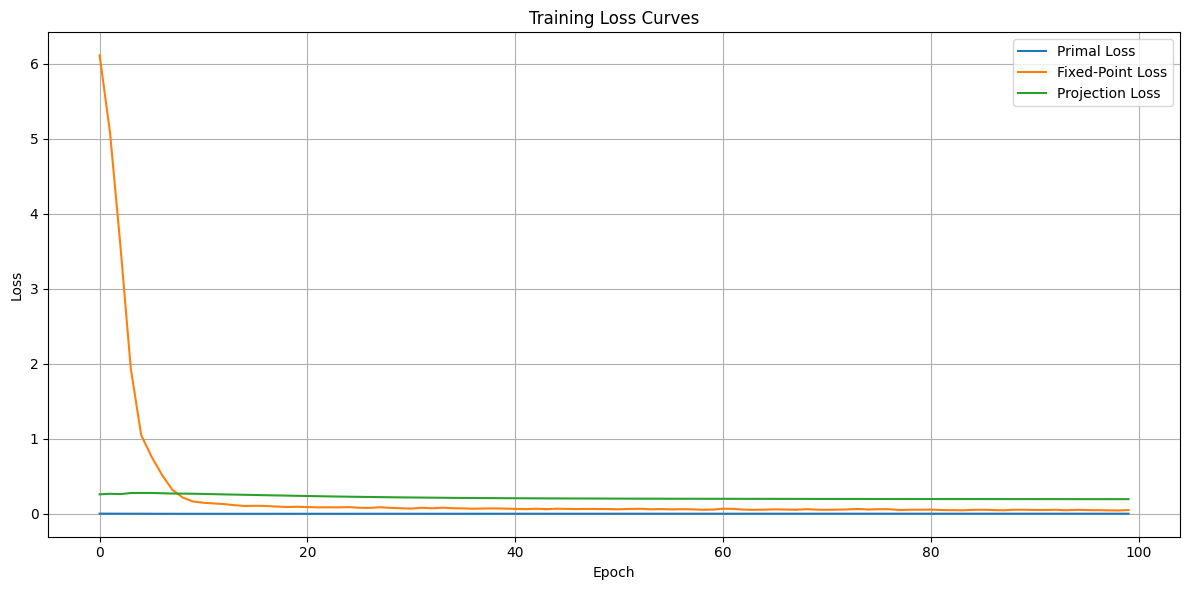

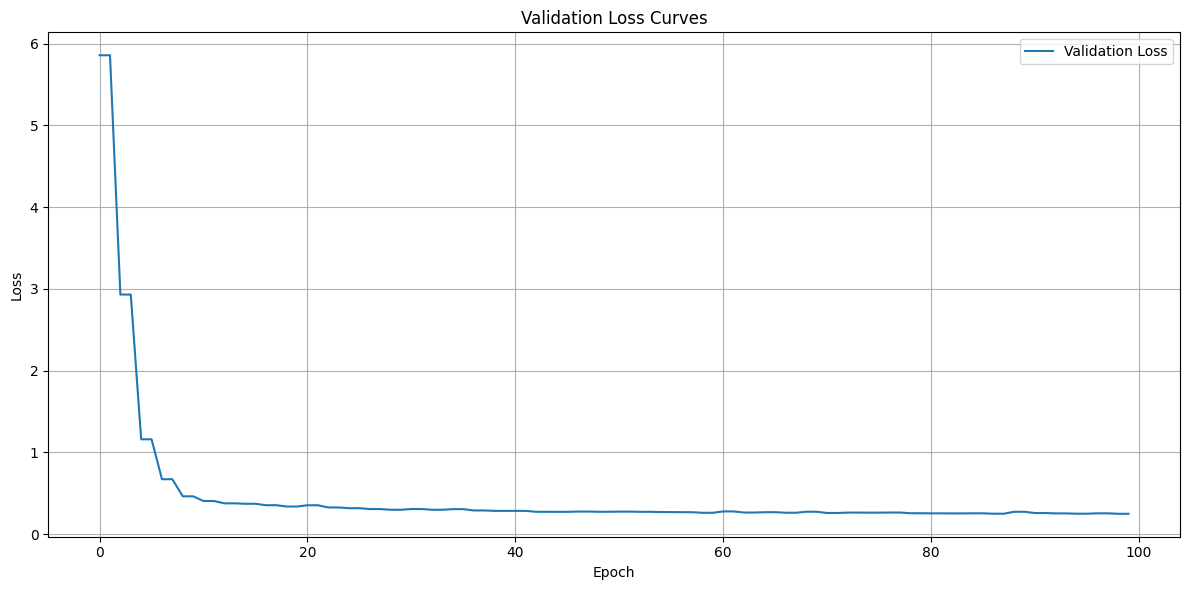

In [15]:
# Plot training losses

plt.figure(figsize=(12, 6))

#plt.plot(avg_train_loss, label='Total Loss')
plt.plot(avg_primal_loss, label='Primal Loss')
plt.plot(avg_fixed_point_loss, label='Fixed-Point Loss')
plt.plot(avg_projection_loss, label='Projection Loss')


plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot validation losses
plt.figure(figsize=(12, 6))
plt.plot(avg_val_loss, label='Validation Loss')

plt.title('Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
avg_train_loss = np.asarray(avg_train_loss)
avg_val_loss = np.asarray(avg_val_loss)
print("Training_loss_end", avg_train_loss[-1])
print("Validation_loss_end", avg_val_loss[-1])

print("max projection_loss", np.max(np.asarray(avg_projection_loss)))
print("min projection_loss", np.min(np.asarray(avg_projection_loss)))

Training_loss_end 0.25330895
Validation_loss_end 0.24762805
max projection_loss 0.27963477
min projection_loss 0.1975176
